In [1]:
import gzip
import pickle
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import os

from tqdm.auto import tqdm
from pymatgen.core import Structure, Composition
from pymatgen.analysis.diffraction.xrd import XRDCalculator

# Import only the needed function from decifer_refactored.utility
from decifer_refactored.utility import (
    generate_continuous_xrd_from_cif,
    extract_formula_nonreduced,
    extract_space_group_symbol,
    space_group_symbol_to_number,
)

def load_comparison_dataframe(file_path):
    """
    Load a gzipped pickle file into a pandas DataFrame.
    """
    with gzip.open(file_path, 'rb') as file:
        return pd.DataFrame(pickle.load(file))


def filter_structure_by_rwp_spacegroup(
    df,
    rwp_min=0.0,
    rwp_max=0.05,
    spacegroup_min=75,
    spacegroup_max=145,
    skip=0
):
    """
    Returns the first row matching:
      rwp < rwp_threshold
      spacegroup_min <= spacegroup_num_sample <= spacegroup_max
    or None if no match is found.
    """
    skipped = 0
    for _, row in df.iterrows():
        if ((rwp_max >= row['rwp'] >= rwp_min) and (spacegroup_max >= space_group_symbol_to_number(row['spacegroup_sym_sample']) >= spacegroup_min)):
            skipped += 1
            if skipped > skip:
                return row
            
    return None


def find_structure_by_substring(
    df,
    substring="CaCd2Ni",
    substring_offset=32,
    skip=0
):
    """
    Returns the first row whose 'cif_sample' contains `substring` at index `substring_offset`.
    or None if no match is found.
    """
    #progress_bar = tqdm(total=len(df), desc=f"Searching for '{substring}'")
    skipped = 0
    for _, row in df.iterrows():
        cif_sample = row['cif_sample']
        if cif_sample[substring_offset:].startswith(substring):
            skipped += 1
            if skipped > skip:
                #progress_bar.close()
                return row
        #progress_bar.update(1)
    #progress_bar.close()
    return None


def generate_disc_xrd(cif_string, qmin=0.0, qmax=10.0):
    """
    Generate a discrete XRD pattern (Q vs. Intensity) using pymatgen's XRDCalculator.
    Returns (q_disc, iq_disc) as torch tensors.
    """
    structure = Structure.from_str(cif_string, fmt="cif")
    xrd_calculator = XRDCalculator(wavelength='CuKa')

    max_possible_q = ((4.0 * np.pi) / xrd_calculator.wavelength) * np.sin(np.radians(180))
    if qmax >= max_possible_q:
        two_theta_range = None
    else:
        tth_min = 2.0 * np.arcsin((qmin * xrd_calculator.wavelength) / (4.0 * np.pi))
        tth_max = 2.0 * np.arcsin((qmax * xrd_calculator.wavelength) / (4.0 * np.pi))
        two_theta_range = (tth_min, tth_max)

    xrd_pattern = xrd_calculator.get_pattern(structure, two_theta_range=two_theta_range)
    theta_radians = torch.tensor(np.radians(xrd_pattern.x / 2.0), dtype=torch.float32)
    q_disc = 4.0 * np.pi * torch.sin(theta_radians) / xrd_calculator.wavelength
    iq_disc = torch.tensor(xrd_pattern.y, dtype=torch.float32)

    return q_disc, iq_disc


def generate_xrd(cif_string, structure_name, qmax=10.0, fwhm_range=(0.05, 0.05)):
    """
    Generate a continuous XRD profile from a CIF string using decifer_refactored.utility.
    Returns a DataFrame with columns 'q' and 'iq'.
    """
    return generate_continuous_xrd_from_cif(
        cif_string,
        qmax=qmax,
        structure_name=structure_name,
        mask_prob=None,
        noise_range=None,
        fwhm_range=fwhm_range
    )


def plot_xrd_comparison(
    xrd1_sample, 
    xrd1_gen,
    xrd1_sample_disc_q,
    xrd1_sample_disc_iq,
    xrd1_gen_disc_q,
    xrd1_gen_disc_iq,
    xrd2_sample_disc_q,
    xrd2_sample_disc_iq,
    xrd2_gen_disc_q,
    xrd2_gen_disc_iq,
    xrd2_sample, 
    xrd2_gen, 
    title_left,
    title_right,
    title1_sample, 
    title1_gen, 
    title1_diff,
    title2_sample, 
    title2_gen, 
    title2_diff,
    rwp1, 
    wd1, 
    rwp2, 
    wd2, 
    output_file, 
    headroom=None,
    bragg_width=0.1,
    bragg_height=0.5,
):
    """
    Plot and save XRD comparisons for two datasets.
    """
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(8, 3), dpi=300)
    
    # Range window for plotting
    m, mm = 850, 50

    ax.plot(
        xrd1_sample['q'][mm:m], xrd1_sample['iq'][mm:m],
        label=title1_sample
    )
    ax.plot(
        xrd1_gen['q'][mm:m], xrd1_gen['iq'][mm:m],
        label=title1_gen
    )
    ax.plot(
        xrd1_sample['q'][mm:m],
        xrd1_sample['iq'][mm:m] - xrd1_gen['iq'][mm:m] - 0.25,
        label=title1_diff
    )
    ax.set(xlabel='$Q\;[\\mathrm{\\AA}^{-1}]$', ylabel='Normalized intensity')
    ax.grid(alpha=0.2)
    ax.legend(fontsize=8)
    ax.set_yticks([])
    ax.set_title(title_left)

    ax.bar(
        xrd1_sample_disc_q,
        height=-np.ones_like(xrd1_sample_disc_iq) * bragg_height,
        width=bragg_width
    )
    ax.bar(
        xrd1_gen_disc_q,
        height=-np.ones_like(xrd1_gen_disc_iq) * bragg_height,
        bottom=-bragg_height,
        width=bragg_width
    )

    ax2.plot(
        xrd2_sample['q'][mm:m], xrd2_sample['iq'][mm:m],
        label=title2_sample
    )
    ax2.plot(
        xrd2_gen['q'][mm:m], xrd2_gen['iq'][mm:m],
        label=title2_gen
    )
    ax2.plot(
        xrd2_sample['q'][mm:m],
        xrd2_sample['iq'][mm:m] - xrd2_gen['iq'][mm:m] - 0.25,
        label=title2_diff
    )
    ax2.set(xlabel='$Q\;[\\mathrm{\\AA}^{-1}]$', ylabel='Normalized intensity')
    ax2.grid(alpha=0.2)
    ax2.legend(fontsize=8)
    ax2.set_yticks([])
    ax2.set_title(title_right)

    ax2.bar(
        xrd2_sample_disc_q,
        height=-np.ones_like(xrd2_sample_disc_iq) * bragg_height,
        width=bragg_width
    )
    ax2.bar(
        xrd2_gen_disc_q,
        height=-np.ones_like(xrd2_gen_disc_iq) * bragg_height,
        bottom=-bragg_height,
        width=bragg_width
    )

    # Optional: Add extra vertical space (headroom) if requested
    if headroom is not None:
        for axis in [ax, ax2]:
            ymin, ymax = axis.get_ylim()
            axis.set_ylim(ymin, ymax + headroom * (ymax - ymin))

    fig.tight_layout()
    plt.show()

    # Save figure
    fig.savefig(output_file, transparent=True)

def plot_single_xrd_comparison(
    xrd_sample,
    xrd_gen,
    xrd_sample_disc_q,
    xrd_sample_disc_iq,
    xrd_gen_disc_q,
    xrd_gen_disc_iq,
    rwp,
    wd,
    output_file,
    headroom=None,
    bragg_width=0.1,
    bragg_height=0.5,
    figsize=(8,3),
    gen_color=None,
    sample_color=None,
    diff_color=None,
    title_sample=None,
    title_gen=None,
    title_diff=None,
):
    """
    Plot and save a single XRD comparison (one subplot).
    
    Args:
        xrd_sample, xrd_gen (DataFrame): Continuous XRD data for the sample and generated.
        q_sample_disc, iq_sample_disc (1D arrays): Discrete XRD (Q, intensity) for the sample.
        q_gen_disc, iq_gen_disc (1D arrays): Discrete XRD (Q, intensity) for the generated data.
        title_sample, title_gen, title_diff (str): Labels for the sample, generated, and difference.
        rwp, wd (float): Refinement metrics for this comparison.
        output_file (str): Filename for output figure.
        headroom (float, optional): Extra vertical space in the y-direction if provided.
        bragg_width (float, optional): Width of the Bragg peak bars.
        bragg_height (float, optional): Height of the Bragg peak bars.
    """

    # Set global font size
    plt.rcParams.update({
        "font.size": 12,  # Global font size
        "axes.titlesize": 14,  # Axes title size
        "axes.labelsize": 14,  # Axes label size
        "xtick.labelsize": 10,  # X-axis tick labels
        "ytick.labelsize": 14,  # Y-axis tick labels
        "legend.fontsize": 14,  # Legend font size
    })
    
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=300)

    # Range window for plotting
    m, mm = 900, 100

    # Plot sample
    ax.plot(
        xrd_sample['q'][mm:m],
        xrd_sample['iq'][mm:m],
        label=title_sample,
        c=sample_color
    )
    # Plot generated
    ax.plot(
        xrd_gen['q'][mm:m],
        xrd_gen['iq'][mm:m],
        label=title_gen,
        c=gen_color
    )
    # Plot difference offset by -0.25
    ax.plot(
        xrd_sample['q'][mm:m],
        xrd_sample['iq'][mm:m] - xrd_gen['iq'][mm:m] - 0.25,
        label=title_diff,
        c=diff_color,
    )

    # Axis styling
    ax.set(xlabel='$Q\;[\\mathrm{\\AA}^{-1}]$', ylabel='Norm. Intensity')
    ax.grid(alpha=0.2)
    ax.set_yticks([])
    # ax.legend(fontsize=8)
    ax.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, frameon=False)
    # ax.set_title(f"$R_{{\\mathrm{{wp}}}}$: {rwp:1.4f}, WD: {wd:1.4f}")

    # Add Bragg reflection bars
    ax.bar(
        xrd_sample_disc_q,
        height=-np.ones_like(xrd_sample_disc_iq) * bragg_height,
        width=bragg_width
    )
    ax.bar(
        xrd_gen_disc_q,
        height=-np.ones_like(xrd_gen_disc_iq) * bragg_height,
        bottom=-bragg_height,
        width=bragg_width
    )

    # Optional: Add extra vertical space (headroom) if requested
    if headroom is not None:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin, ymax + headroom * (ymax - ymin))
    ax.set_xlim(mm/100, m/100)

    fig.tight_layout()
    plt.show()
    fig.savefig(output_file, transparent=True)


Reduced Formula / Spacegroup, Target 1: Sc12Sb17 / I-43m
Reduced Formula / Spacegroup, Generated 1: Sc12Sb17 / I-43m


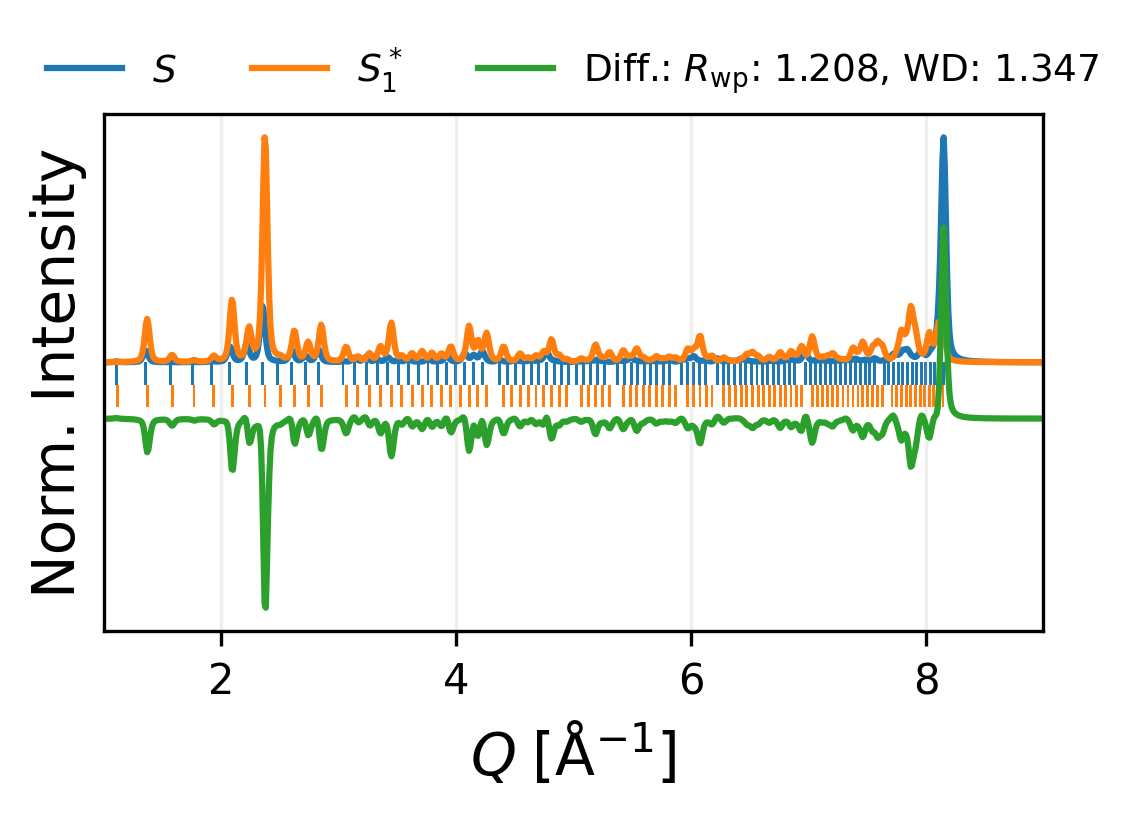

Done! Outputs saved in folder: generated_examples_CinnAMON_Sc12Sb17
Reduced Formula / Spacegroup, Target 1: Sc12Sb17 / I-43m
Reduced Formula / Spacegroup, Generated 1: Sc12Sb17 / I-43m


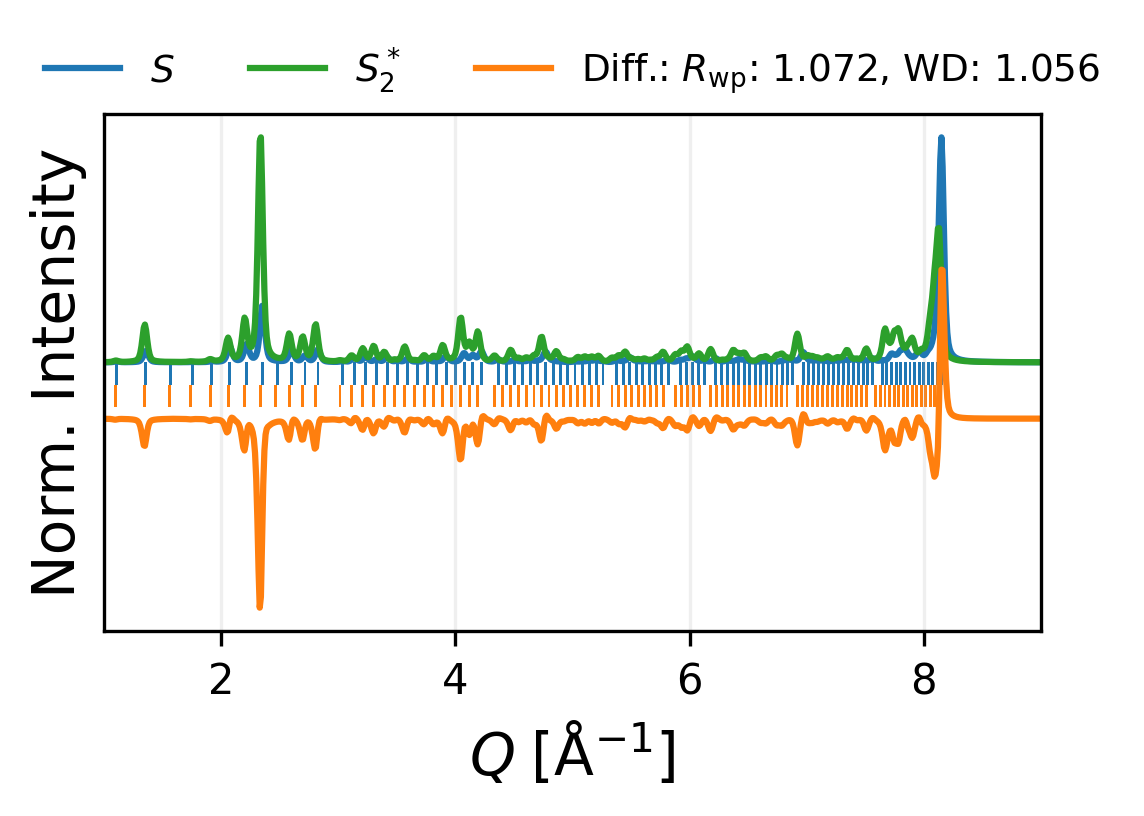

Done! Outputs saved in folder: generated_examples_CinnAMON_Sc12Sb17


In [6]:

comparison_file_1 = (
    "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer_(Comp_N-0p00_B-0p05).pkl.gz"
)
df_1 = load_comparison_dataframe(comparison_file_1)


row_1 = find_structure_by_substring(
    df_1,
    substring="Sc12Sb17",
    substring_offset=32,
    skip=0
)
if row_1 is None:
    raise ValueError("No matching row found in df_1 for specified Rwp/spacegroup criteria.")

rwp_1 = row_1['rwp']
wd_1 = row_1['wd']
cif_target_1 = row_1['cif_sample']
cif_generated_1 = row_1['cif_gen']

# Make folder and find desired formula
reduced_formula_target_1 = Composition(extract_formula_nonreduced(cif_target_1)).reduced_formula
spacegroup_target_1 = extract_space_group_symbol(cif_target_1)
print("Reduced Formula / Spacegroup, Target 1:", reduced_formula_target_1, '/', spacegroup_target_1)
reduced_formula_generated_1 = Composition(extract_formula_nonreduced(cif_generated_1)).reduced_formula
spacegroup_generated_1 = extract_space_group_symbol(cif_generated_1)
print("Reduced Formula / Spacegroup, Generated 1:", reduced_formula_generated_1, '/', spacegroup_generated_1)

folder_name = f"generated_examples_CinnAMON_{reduced_formula_target_1}"
os.makedirs(folder_name, exist_ok=True) # Create the folder if not exists

# We'll rename them to something more descriptive
target_1_file = os.path.join(folder_name, "target.cif")
gen_1_file = os.path.join(folder_name, "generated_1.cif")
with open(target_1_file, "w") as f:
    f.write(cif_target_1)
with open(gen_1_file, "w") as f:
    f.write(cif_generated_1)

q_target_1, iq_target_1 = generate_disc_xrd(cif_target_1)
q_gen_1, iq_gen_1 = generate_disc_xrd(cif_generated_1)
xrd_target_1 = generate_xrd(cif_target_1, structure_name="target")
xrd_gen_1 = generate_xrd(cif_generated_1, structure_name="generated_1")


# We'll name the PNG according to the substring, e.g. "CaCd2Ni_comparison.png"
png_name = os.path.join(folder_name, f"{reduced_formula_target_1}_comparison_single_1.png")
plot_single_xrd_comparison(
    xrd_sample=xrd_target_1,
    xrd_gen=xrd_gen_1,
    xrd_sample_disc_q=q_target_1,
    xrd_sample_disc_iq=iq_target_1,
    xrd_gen_disc_q=q_gen_1,
    xrd_gen_disc_iq=iq_gen_1,
    title_sample=f"$S$",#: {reduced_formula_target_1}, {spacegroup_target_1}",
    title_gen=f"$S_1^*$",#: {reduced_formula_generated_1}, {spacegroup_generated_1}",
    title_diff=f"Diff.: $R_{{\\mathrm{{wp}}}}$: {rwp_1:1.3f}, WD: {wd_1:1.3f}",
    rwp=rwp_1,
    wd=wd_1,
    output_file=png_name,
    bragg_width=0.025,
    bragg_height=0.1,
    figsize=(4,3),
)
print(f"Done! Outputs saved in folder: {folder_name}")

comparison_file_1 = (
    "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer_(CompSG_N-0p00_B-0p05).pkl.gz"
)
df_1 = load_comparison_dataframe(comparison_file_1)

row_1 = find_structure_by_substring(
    df_1,
    substring="Sc12Sb17",
    substring_offset=32,
    skip=0
)
if row_1 is None:
    raise ValueError("No matching row found in df_1 for specified Rwp/spacegroup criteria.")

rwp_1 = row_1['rwp']
wd_1 = row_1['wd']
cif_target_1 = row_1['cif_sample']
cif_generated_1 = row_1['cif_gen']

# Make folder and find desired formula
reduced_formula_target_1 = Composition(extract_formula_nonreduced(cif_target_1)).reduced_formula
spacegroup_target_1 = extract_space_group_symbol(cif_target_1)
print("Reduced Formula / Spacegroup, Target 1:", reduced_formula_target_1, '/', spacegroup_target_1)
reduced_formula_generated_1 = Composition(extract_formula_nonreduced(cif_generated_1)).reduced_formula
spacegroup_generated_1 = extract_space_group_symbol(cif_generated_1)
print("Reduced Formula / Spacegroup, Generated 1:", reduced_formula_generated_1, '/', spacegroup_generated_1)

folder_name = f"generated_examples_CinnAMON_{reduced_formula_target_1}"
os.makedirs(folder_name, exist_ok=True) # Create the folder if not exists

# We'll rename them to something more descriptive
# target_1_file = os.path.join(folder_name, "target_.cif")
gen_1_file = os.path.join(folder_name, "generated_2.cif")
with open(target_1_file, "w") as f:
    f.write(cif_target_1)
with open(gen_1_file, "w") as f:
    f.write(cif_generated_1)
    
q_target_1, iq_target_1 = generate_disc_xrd(cif_target_1)
q_gen_1, iq_gen_1 = generate_disc_xrd(cif_generated_1)
xrd_target_1 = generate_xrd(cif_target_1, structure_name="target")
xrd_gen_1 = generate_xrd(cif_generated_1, structure_name="generated_2")


# We'll name the PNG according to the substring, e.g. "CaCd2Ni_comparison.png"
png_name = os.path.join(folder_name, f"{reduced_formula_target_1}_comparison_single_2.png")
plot_single_xrd_comparison(
    xrd_sample=xrd_target_1,
    xrd_gen=xrd_gen_1,
    xrd_sample_disc_q=q_target_1,
    xrd_sample_disc_iq=iq_target_1,
    xrd_gen_disc_q=q_gen_1,
    xrd_gen_disc_iq=iq_gen_1,
    title_sample=f"$S$",# {reduced_formula_target_1}, {spacegroup_target_1}",
    title_gen=f"$S_2^*$",# {reduced_formula_generated_1}, {spacegroup_generated_1}",
    title_diff=f"Diff.: $R_{{\\mathrm{{wp}}}}$: {rwp_1:1.3f}, WD: {wd_1:1.3f}",
    rwp=rwp_1,
    wd=wd_1,
    output_file=png_name,
    bragg_width=0.025,
    bragg_height=0.1,
    figsize=(4,3),
    gen_color='#2ca02c',
)
print(f"Done! Outputs saved in folder: {folder_name}")

Reduced Formula / Spacegroup, Target 1: CaCd2Ni / Fm-3m
Reduced Formula / Spacegroup, Generated 1: CaNbVIn / F-43m


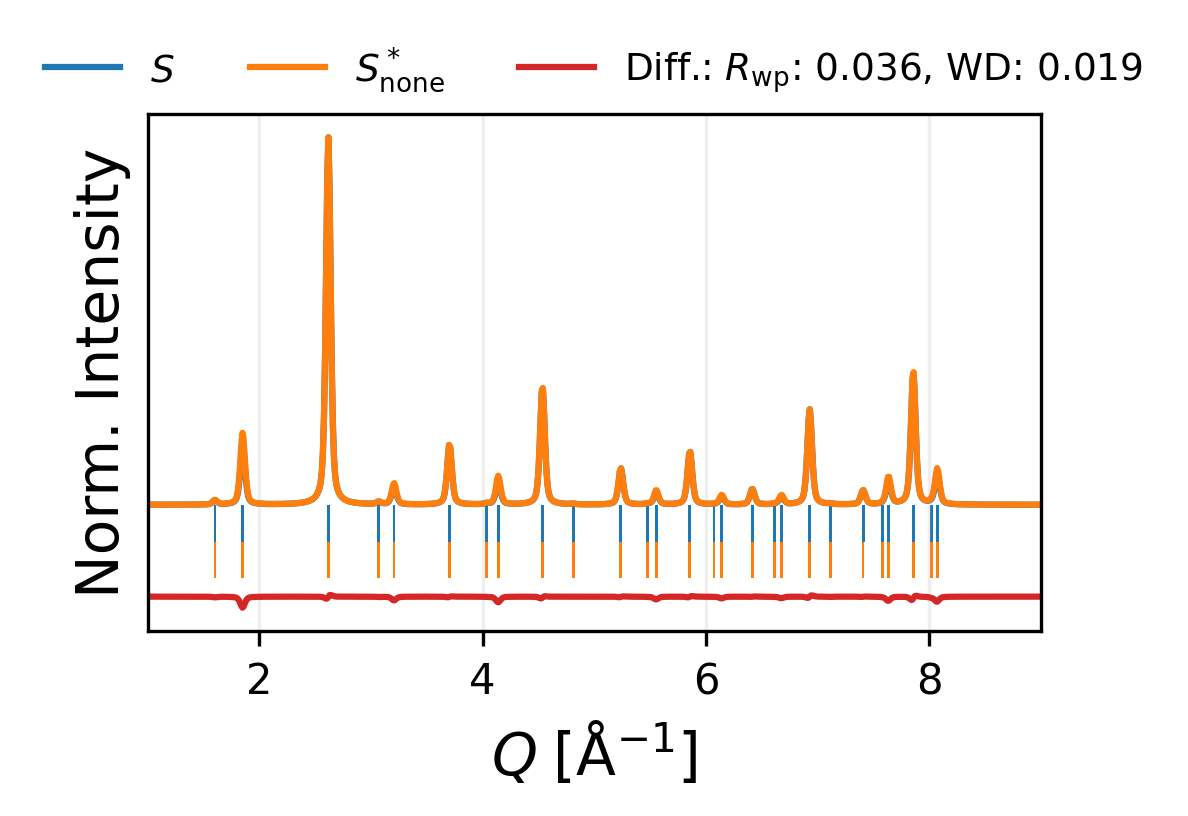

Done! Outputs saved in folder: generated_examples_CinnAMON_CaCd2Ni
Reduced Formula / Spacegroup, Target 1: CaCd2Ni / Fm-3m
Reduced Formula / Spacegroup, Generated 1: CaCd2Ni / Fm-3m


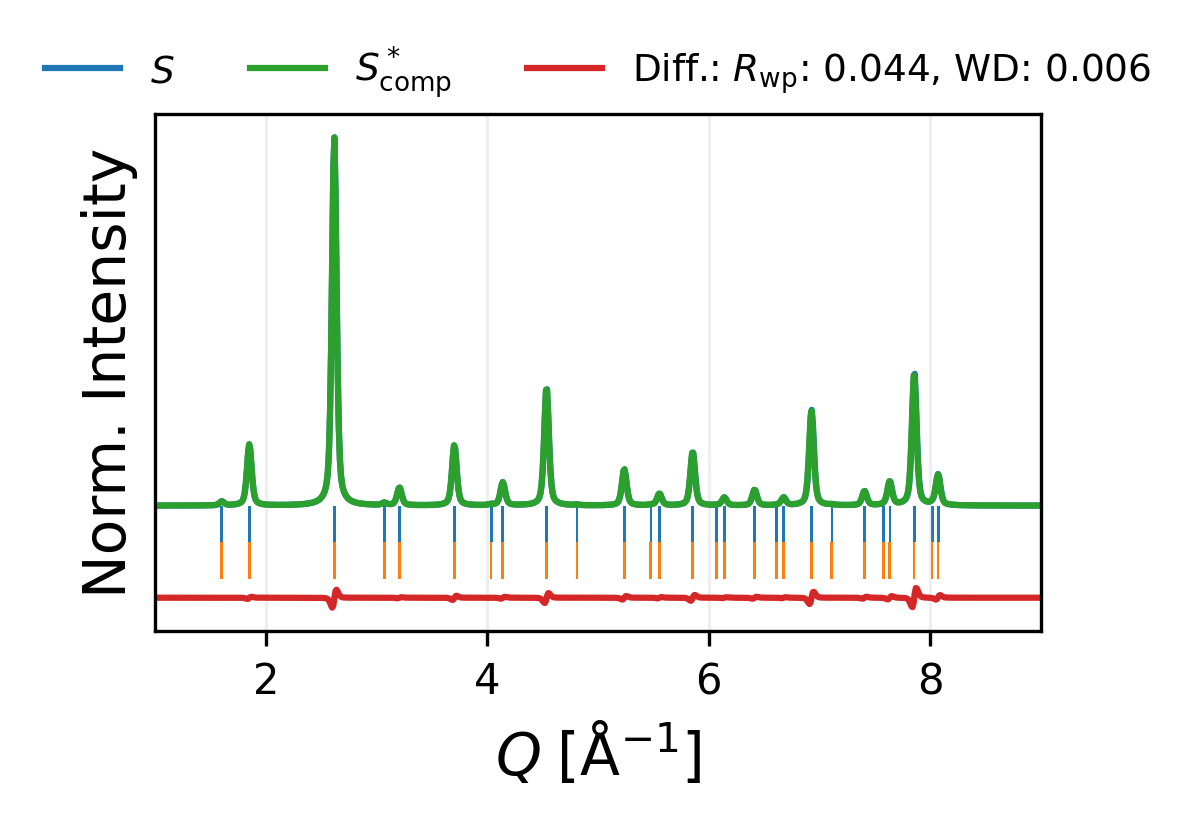

Done! Outputs saved in folder: generated_examples_CinnAMON_CaCd2Ni


In [248]:
# ---------------------------------------------------------------- #
# 1. Load data from the first comparison file
# ---------------------------------------------------------------- #
comparison_file_1 = (
    "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer_(None_N-0p00_B-0p05).pkl.gz"
)
df_1 = load_comparison_dataframe(comparison_file_1)

# ---------------------------------------------------------------- #
# 2. Filter by rwp and spacegroup
# ---------------------------------------------------------------- #
row_1 = find_structure_by_substring(
    df_1,
    substring="CaCd2Ni",
    substring_offset=32,
    skip=0
)
if row_1 is None:
    raise ValueError("No matching row found in df_1 for specified Rwp/spacegroup criteria.")

rwp_1 = row_1['rwp']
wd_1 = row_1['wd']
cif_target_1 = row_1['cif_sample']
cif_generated_1 = row_1['cif_gen']

# Make folder and find desired formula
reduced_formula_target_1 = Composition(extract_formula_nonreduced(cif_target_1)).reduced_formula
spacegroup_target_1 = extract_space_group_symbol(cif_target_1)
print("Reduced Formula / Spacegroup, Target 1:", reduced_formula_target_1, '/', spacegroup_target_1)
reduced_formula_generated_1 = Composition(extract_formula_nonreduced(cif_generated_1)).reduced_formula
spacegroup_generated_1 = extract_space_group_symbol(cif_generated_1)
print("Reduced Formula / Spacegroup, Generated 1:", reduced_formula_generated_1, '/', spacegroup_generated_1)

folder_name = f"generated_examples_CinnAMON_{reduced_formula_target_1}"
os.makedirs(folder_name, exist_ok=True) # Create the folder if not exists

# ---------------------------------------------------------------- #
# 3. Write out these CIFs as separate files in the folder
# ---------------------------------------------------------------- #
# We'll rename them to something more descriptive
target_1_file = os.path.join(folder_name, "target.cif")
gen_1_file = os.path.join(folder_name, "generated_1.cif")
with open(target_1_file, "w") as f:
    f.write(cif_target_1)
with open(gen_1_file, "w") as f:
    f.write(cif_generated_1)
    
# ---------------------------------------------------------------- #
# 4. Generate discrete and continuous XRD for target_1 and gen_1
# ---------------------------------------------------------------- #
q_target_1, iq_target_1 = generate_disc_xrd(cif_target_1)
q_gen_1, iq_gen_1 = generate_disc_xrd(cif_generated_1)
xrd_target_1 = generate_xrd(cif_target_1, structure_name="target")
xrd_gen_1 = generate_xrd(cif_generated_1, structure_name="generated_1")


# ---------------------------------------------------------------- #
# 9. Finally, plot the comparison
# ---------------------------------------------------------------- #
# We'll name the PNG according to the substring, e.g. "CaCd2Ni_comparison.png"
png_name = os.path.join(folder_name, f"{reduced_formula_target_1}_comparison_single_1.png")
plot_single_xrd_comparison(
    xrd_sample=xrd_target_1,
    xrd_gen=xrd_gen_1,
    xrd_sample_disc_q=q_target_1,
    xrd_sample_disc_iq=iq_target_1,
    xrd_gen_disc_q=q_gen_1,
    xrd_gen_disc_iq=iq_gen_1,
    title_sample="$S$",#: {reduced_formula_target_1}, {spacegroup_target_1}",
    title_gen="$S_{\mathrm{none}}^*$",#: {reduced_formula_generated_1}, {spacegroup_generated_1}",
    title_diff=f"Diff.: $R_{{\\mathrm{{wp}}}}$: {rwp_1:1.3f}, WD: {wd_1:1.3f}",
    rwp=rwp_1,
    wd=wd_1,
    output_file=png_name,
    bragg_width=0.025,
    bragg_height=0.1,
    figsize=(4,3),
)
print(f"Done! Outputs saved in folder: {folder_name}")

# ---------------------------------------------------------------- #
# 1. Load data from the first comparison file
# ---------------------------------------------------------------- #
comparison_file_1 = (
    "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer_(Comp_N-0p00_B-0p05).pkl.gz"
)
df_1 = load_comparison_dataframe(comparison_file_1)

# ---------------------------------------------------------------- #
# 2. Filter by rwp and spacegroup
# ---------------------------------------------------------------- #
row_1 = find_structure_by_substring(
    df_1,
    substring="CaCd2Ni",
    substring_offset=32,
    skip=0
)
if row_1 is None:
    raise ValueError("No matching row found in df_1 for specified Rwp/spacegroup criteria.")

rwp_1 = row_1['rwp']
wd_1 = row_1['wd']
cif_target_1 = row_1['cif_sample']
cif_generated_1 = row_1['cif_gen']

# Make folder and find desired formula
reduced_formula_target_1 = Composition(extract_formula_nonreduced(cif_target_1)).reduced_formula
spacegroup_target_1 = extract_space_group_symbol(cif_target_1)
print("Reduced Formula / Spacegroup, Target 1:", reduced_formula_target_1, '/', spacegroup_target_1)
reduced_formula_generated_1 = Composition(extract_formula_nonreduced(cif_generated_1)).reduced_formula
spacegroup_generated_1 = extract_space_group_symbol(cif_generated_1)
print("Reduced Formula / Spacegroup, Generated 1:", reduced_formula_generated_1, '/', spacegroup_generated_1)

folder_name = f"generated_examples_CinnAMON_{reduced_formula_target_1}"
os.makedirs(folder_name, exist_ok=True) # Create the folder if not exists

# ---------------------------------------------------------------- #
# 3. Write out these CIFs as separate files in the folder
# ---------------------------------------------------------------- #
# We'll rename them to something more descriptive
# target_1_file = os.path.join(folder_name, "target.cif")
gen_1_file = os.path.join(folder_name, "generated_2.cif")
with open(target_1_file, "w") as f:
    f.write(cif_target_1)
with open(gen_1_file, "w") as f:
    f.write(cif_generated_1)
    
# ---------------------------------------------------------------- #
# 4. Generate discrete and continuous XRD for target_1 and gen_1
# ---------------------------------------------------------------- #
q_target_1, iq_target_1 = generate_disc_xrd(cif_target_1)
q_gen_1, iq_gen_1 = generate_disc_xrd(cif_generated_1)
xrd_target_1 = generate_xrd(cif_target_1, structure_name="target")
xrd_gen_1 = generate_xrd(cif_generated_1, structure_name="generated")


# ---------------------------------------------------------------- #
# 9. Finally, plot the comparison
# ---------------------------------------------------------------- #
# We'll name the PNG according to the substring, e.g. "CaCd2Ni_comparison.png"
png_name = os.path.join(folder_name, f"{reduced_formula_target_1}_comparison_single_2.png")
plot_single_xrd_comparison(
    xrd_sample=xrd_target_1,
    xrd_gen=xrd_gen_1,
    xrd_sample_disc_q=q_target_1,
    xrd_sample_disc_iq=iq_target_1,
    xrd_gen_disc_q=q_gen_1,
    xrd_gen_disc_iq=iq_gen_1,
    title_sample="$S$",# {reduced_formula_target_1}, {spacegroup_target_1}",
    title_gen="$S_{\mathrm{comp}}^*$",# {reduced_formula_generated_1}, {spacegroup_generated_1}",
    title_diff=f"Diff.: $R_{{\\mathrm{{wp}}}}$: {rwp_1:1.3f}, WD: {wd_1:1.3f}",
    rwp=rwp_1,
    wd=wd_1,
    output_file=png_name,
    bragg_width=0.025,
    bragg_height=0.1,
    figsize=(4,3),
    gen_color='#2ca02c',
)
print(f"Done! Outputs saved in folder: {folder_name}")

Reduced Formula / Spacegroup, Target: Al2ZnSe4 / I-4
Reduced Formula / Spacegroup, Generated 1: Al2ZnSe4 / I-4


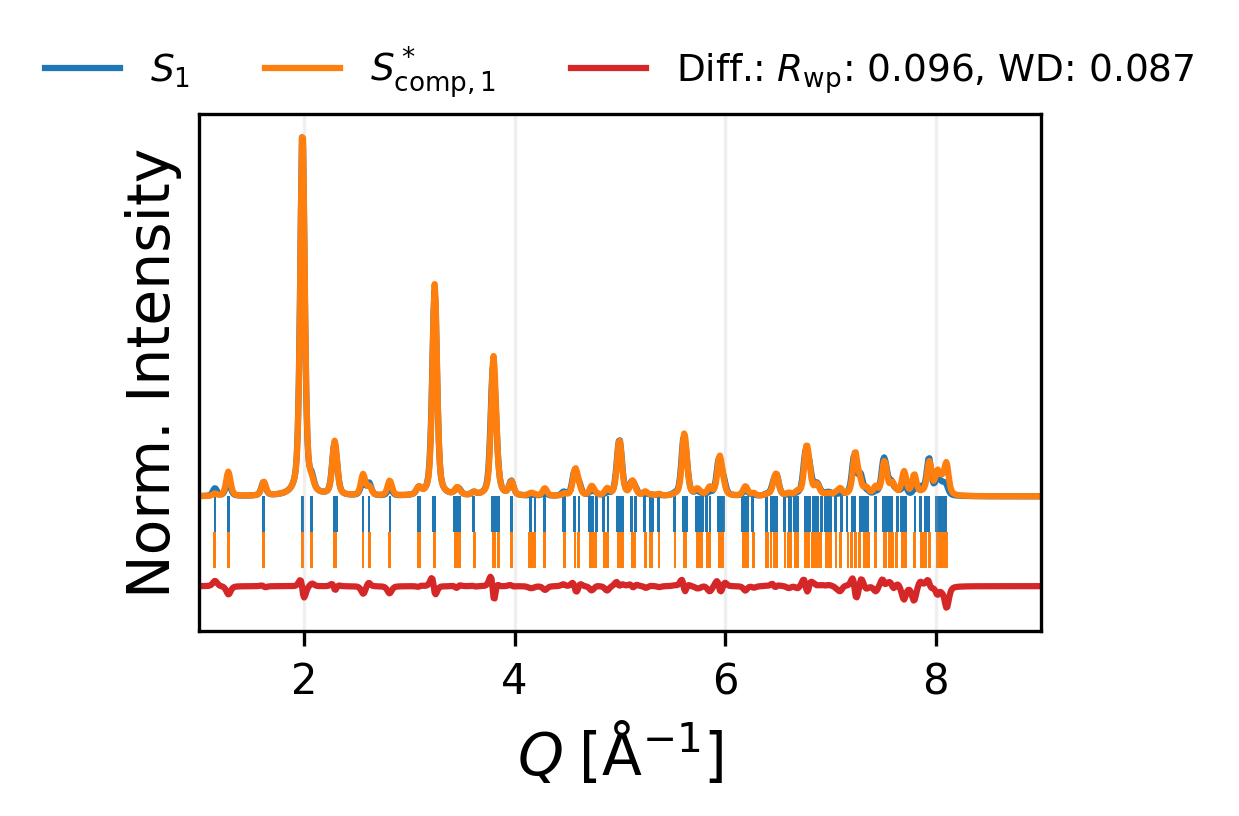

Done! Outputs saved in folder: generated_examples_CHILI_Al2ZnSe4
Reduced Formula / Spacegroup, Target: Ag3AsS3 / R3c
Reduced Formula / Spacegroup, Generated 1: Ag3AsS3 / R-3


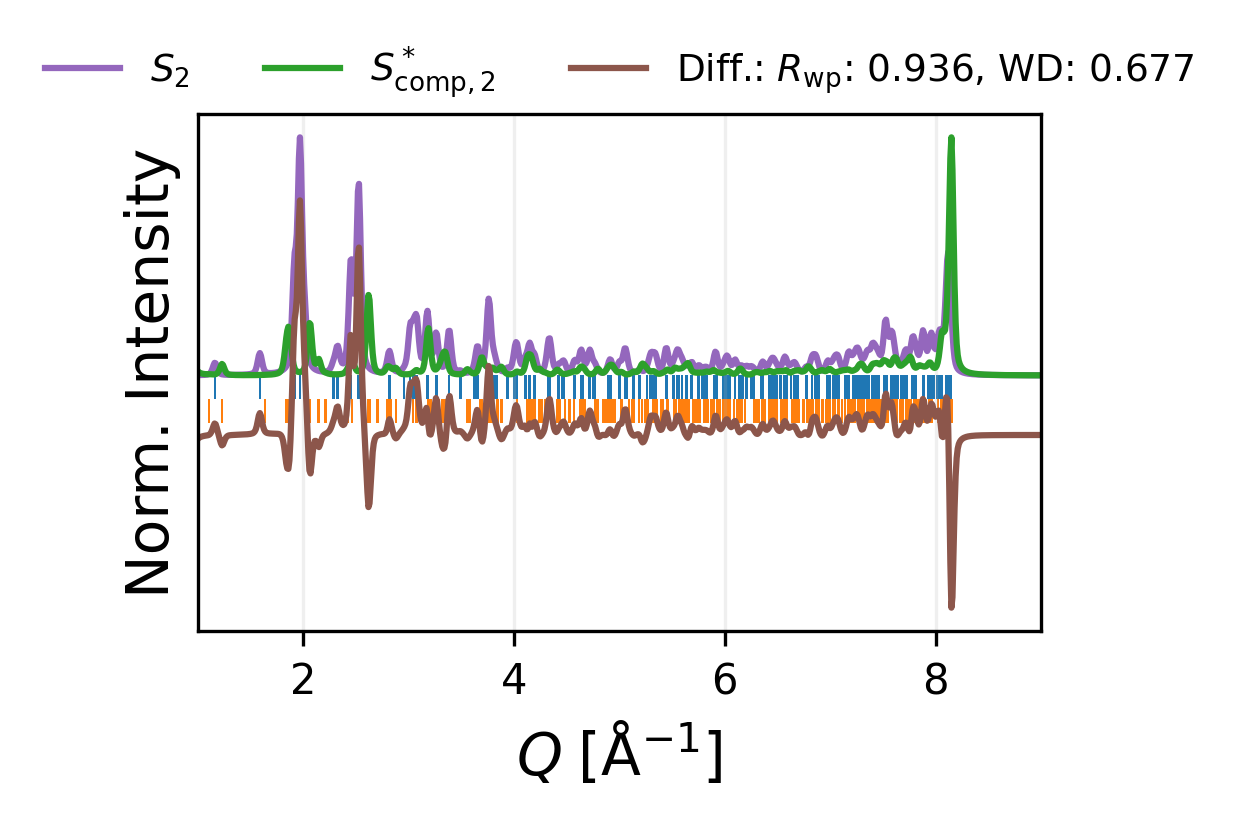

Done! Outputs saved in folder: generated_examples_CHILI_Ag3AsS3


In [258]:
# ---------------------------------------------------------------- #
# 1. Load data from the first comparison file
# ---------------------------------------------------------------- #
comparison_file_1 = (
    "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer_chili_(Comp_N-0p00_B-0p05).pkl.gz"
)
df_1 = load_comparison_dataframe(comparison_file_1)

# ---------------------------------------------------------------- #
# 2. Filter by rwp and spacegroup
# ---------------------------------------------------------------- #
row_1 = find_structure_by_substring(
    df_1,
    substring="Al2ZnSe4",
    substring_offset=32,
    skip=0
)
if row_1 is None:
    raise ValueError("No matching row found in df_1 for specified Rwp/spacegroup criteria.")

rwp_1 = row_1['rwp']
wd_1 = row_1['wd']
cif_target_1 = row_1['cif_sample']
cif_generated_1 = row_1['cif_gen']

# Make folder and find desired formula
reduced_formula_target_1 = Composition(extract_formula_nonreduced(cif_target_1)).reduced_formula
spacegroup_target_1 = extract_space_group_symbol(cif_target_1)
print("Reduced Formula / Spacegroup, Target:", reduced_formula_target_1, '/', spacegroup_target_1)
reduced_formula_generated_1 = Composition(extract_formula_nonreduced(cif_generated_1)).reduced_formula
spacegroup_generated_1 = extract_space_group_symbol(cif_generated_1)
print("Reduced Formula / Spacegroup, Generated 1:", reduced_formula_generated_1, '/', spacegroup_generated_1)

folder_name = f"generated_examples_CHILI_{reduced_formula_target_1}"
os.makedirs(folder_name, exist_ok=True) # Create the folder if not exists

# ---------------------------------------------------------------- #
# 3. Write out these CIFs as separate files in the folder
# ---------------------------------------------------------------- #
# We'll rename them to something more descriptive
target_1_file = os.path.join(folder_name, "target.cif")
gen_1_file = os.path.join(folder_name, "generated_1.cif")
with open(target_1_file, "w") as f:
    f.write(cif_target_1)
with open(gen_1_file, "w") as f:
    f.write(cif_generated_1)
    
# ---------------------------------------------------------------- #
# 4. Generate discrete and continuous XRD for target_1 and gen_1
# ---------------------------------------------------------------- #
q_target_1, iq_target_1 = generate_disc_xrd(cif_target_1)
q_gen_1, iq_gen_1 = generate_disc_xrd(cif_generated_1)
xrd_target_1 = generate_xrd(cif_target_1, structure_name="target")
xrd_gen_1 = generate_xrd(cif_generated_1, structure_name="generated_1")


# ---------------------------------------------------------------- #
# 9. Finally, plot the comparison
# ---------------------------------------------------------------- #
# We'll name the PNG according to the substring, e.g. "CaCd2Ni_comparison.png"
png_name = os.path.join(folder_name, f"{reduced_formula_target_1}_comparison_single_1.png")
plot_single_xrd_comparison(
    xrd_sample=xrd_target_1,
    xrd_gen=xrd_gen_1,
    xrd_sample_disc_q=q_target_1,
    xrd_sample_disc_iq=iq_target_1,
    xrd_gen_disc_q=q_gen_1,
    xrd_gen_disc_iq=iq_gen_1,
    title_sample="$S_1$",#: {reduced_formula_target_1}, {spacegroup_target_1}",
    title_gen="$S_{\mathrm{comp},1}^*$",#: {reduced_formula_generated_1}, {spacegroup_generated_1}",
    title_diff=f"Diff.: $R_{{\\mathrm{{wp}}}}$: {rwp_1:1.3f}, WD: {wd_1:1.3f}",
    rwp=rwp_1,
    wd=wd_1,
    output_file=png_name,
    bragg_width=0.025,
    bragg_height=0.1,
    figsize=(4,3),
    diff_color='#d62728'
)
print(f"Done! Outputs saved in folder: {folder_name}")

# ---------------------------------------------------------------- #
# 1. Load data from the first comparison file
# ---------------------------------------------------------------- #
comparison_file_1 = (
    "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer_chili_(Comp_N-0p00_B-0p05).pkl.gz"
)
df_1 = load_comparison_dataframe(comparison_file_1)

# ---------------------------------------------------------------- #
# 2. Filter by rwp and spacegroup
# ---------------------------------------------------------------- #
row_1 = find_structure_by_substring(
    df_1,
    substring="Ag3AsS3",
    substring_offset=32,
    skip=0
)
if row_1 is None:
    raise ValueError("No matching row found in df_1 for specified Rwp/spacegroup criteria.")

rwp_1 = row_1['rwp']
wd_1 = row_1['wd']
cif_target_1 = row_1['cif_sample']
cif_generated_1 = row_1['cif_gen']

# Make folder and find desired formula
reduced_formula_target_1 = Composition(extract_formula_nonreduced(cif_target_1)).reduced_formula
spacegroup_target_1 = extract_space_group_symbol(cif_target_1)
print("Reduced Formula / Spacegroup, Target:", reduced_formula_target_1, '/', spacegroup_target_1)
reduced_formula_generated_1 = Composition(extract_formula_nonreduced(cif_generated_1)).reduced_formula
spacegroup_generated_1 = extract_space_group_symbol(cif_generated_1)
print("Reduced Formula / Spacegroup, Generated 1:", reduced_formula_generated_1, '/', spacegroup_generated_1)

folder_name = f"generated_examples_CHILI_{reduced_formula_target_1}"
os.makedirs(folder_name, exist_ok=True) # Create the folder if not exists

# ---------------------------------------------------------------- #
# 3. Write out these CIFs as separate files in the folder
# ---------------------------------------------------------------- #
# We'll rename them to something more descriptive
target_1_file = os.path.join(folder_name, "target.cif")
gen_1_file = os.path.join(folder_name, "generated_1.cif")
with open(target_1_file, "w") as f:
    f.write(cif_target_1)
with open(gen_1_file, "w") as f:
    f.write(cif_generated_1)
    
# ---------------------------------------------------------------- #
# 4. Generate discrete and continuous XRD for target_1 and gen_1
# ---------------------------------------------------------------- #
q_target_1, iq_target_1 = generate_disc_xrd(cif_target_1)
q_gen_1, iq_gen_1 = generate_disc_xrd(cif_generated_1)
xrd_target_1 = generate_xrd(cif_target_1, structure_name="target")
xrd_gen_1 = generate_xrd(cif_generated_1, structure_name="generated")


# ---------------------------------------------------------------- #
# 9. Finally, plot the comparison
# ---------------------------------------------------------------- #
# We'll name the PNG according to the substring, e.g. "CaCd2Ni_comparison.png"
png_name = os.path.join(folder_name, f"{reduced_formula_target_1}_comparison_single_2.png")
plot_single_xrd_comparison(
    xrd_sample=xrd_target_1,
    xrd_gen=xrd_gen_1,
    xrd_sample_disc_q=q_target_1,
    xrd_sample_disc_iq=iq_target_1,
    xrd_gen_disc_q=q_gen_1,
    xrd_gen_disc_iq=iq_gen_1,
    title_sample="$S_2$",# {reduced_formula_target_1}, {spacegroup_target_1}",
    title_gen="$S_{\mathrm{comp},2}^*$",# {reduced_formula_generated_1}, {spacegroup_generated_1}",
    title_diff=f"Diff.: $R_{{\\mathrm{{wp}}}}$: {rwp_1:1.3f}, WD: {wd_1:1.3f}",
    rwp=rwp_1,
    wd=wd_1,
    output_file=png_name,
    bragg_width=0.025,
    bragg_height=0.1,
    figsize=(4,3),
    sample_color='#9467bd',
    gen_color='#2ca02c',
    diff_color='#8c564b'
)
print(f"Done! Outputs saved in folder: {folder_name}")